## Building Project with Agent
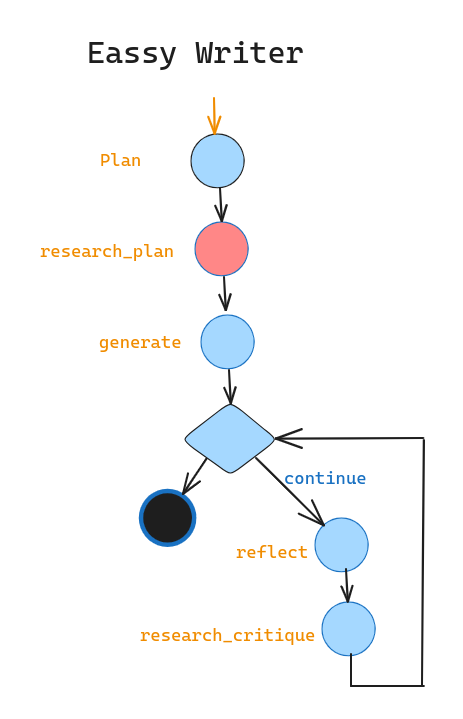

In [1]:
import os
import operator
from typing import TypedDict, Annotated, List

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain_core.pydantic_v1 import BaseModel
from langchain_openai import ChatOpenAI
from tavily import TavilyClient

from IPython.display import Image, Markdown
from dotenv import load_dotenv

# load the .env file
load_dotenv()

True

In [2]:
memory = SqliteSaver.from_conn_string(":memory:")

model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
tavily = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

In [3]:
PLAN_PROMPT = """
You are an expert writer tasked with writing a high level outline of an eassy. \
Write such an outline for the user provided topic. Give an outline of eassy along with any relevant notes or instructions for the sections.
"""

WRITER_PROMPT = """
You are an eassy assistant tasked with writing excellent 5-paragraph eassys. \
Generate the best eassy possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of ypur previous attempts. \

--------

{content}"""

REFLECTION_PROMPT = """
You are a teacher grading an eassy submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc.
"""

RESEARCH_PLAN_PROMPT = """
You are a researcher charged with providing information that can \
be used when writing the following eassy. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max
"""

RESEARCH_CRITIQUE_PROMPT = """
You are a researcher charged with providing information that can \
be used when making any requested revisions (as oulined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.
"""

In [4]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [5]:
class Queries(BaseModel):
    queries: List[str]

In [6]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state["task"])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [7]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state["task"])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [8]:
def generation_node(state: AgentState):
    content = "\n\n".join(["content"] or [])
    user_message = HumanMessage(content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        user_message,
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }

In [9]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft']),
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [10]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [11]:
def should_continue(state):
    if state['revision_number'] > state['max_revisions']:
        return END
    return 'reflect'

In [12]:
builder = StateGraph(AgentState)

In [13]:
builder.add_node('planner', plan_node)
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)
builder.add_node('research_plan', research_plan_node)
builder.add_node('research_critique', research_critique_node)

builder.set_entry_point('planner')

In [14]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)

builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [15]:
# compile the graph
graph = builder.compile(checkpointer=memory)

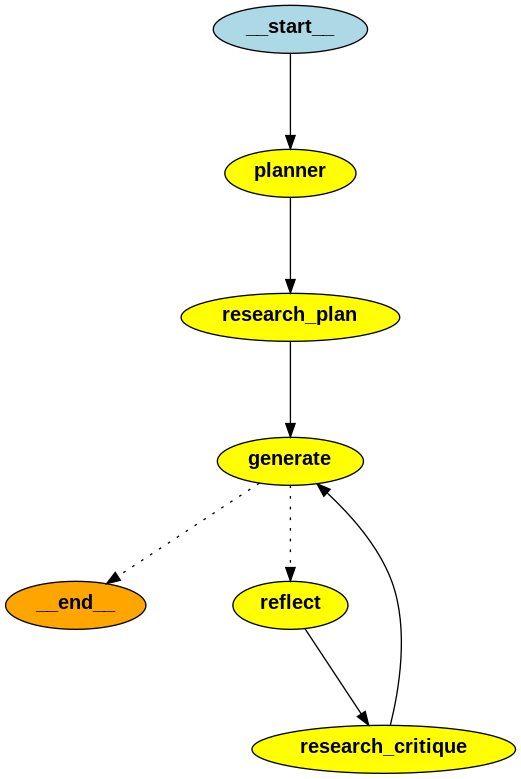

In [16]:
Image(graph.get_graph().draw_png())

In [17]:
results = []

thread = {
    "configurable": {'thread_id': '1'}
}
for s in graph.stream({
    'task': 'What is the difference between langchain and langsmith',
    'max_revisions': 2,
    'revision_number': 1
}, thread):
    results.append(s)
    print(s)

{'planner': {'plan': '**Essay Outline: The Difference Between Langchain and Langsmith**\n\nI. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Importance of understanding the differences between the two concepts\n    C. Thesis statement: Exploring the distinctions between Langchain and Langsmith\n\nII. Langchain\n    A. Definition of Langchain\n    B. Characteristics and key features\n    C. Examples of how Langchain is used in language processing\n    D. Importance of Langchain in computational linguistics\n\nIII. Langsmith\n    A. Definition of Langsmith\n    B. Characteristics and key features\n    C. Examples of how Langsmith is applied in linguistic analysis\n    D. Significance of Langsmith in language studies\n\nIV. Comparison between Langchain and Langsmith\n    A. Differentiation in terms of purpose and application\n    B. Contrasting methodologies and techniques used in Langchain and Langsmith\n    C. Impact of Langchain and Langsmith on language researc

### Planner

In [20]:
Markdown(results[0]["planner"]["plan"])

**Essay Outline: The Difference Between Langchain and Langsmith**

I. Introduction
    A. Brief overview of Langchain and Langsmith
    B. Importance of understanding the differences between the two concepts
    C. Thesis statement: Exploring the distinctions between Langchain and Langsmith

II. Langchain
    A. Definition of Langchain
    B. Characteristics and key features
    C. Examples of how Langchain is used in language processing
    D. Importance of Langchain in computational linguistics

III. Langsmith
    A. Definition of Langsmith
    B. Characteristics and key features
    C. Examples of how Langsmith is applied in linguistic analysis
    D. Significance of Langsmith in language studies

IV. Comparison between Langchain and Langsmith
    A. Differentiation in terms of purpose and application
    B. Contrasting methodologies and techniques used in Langchain and Langsmith
    C. Impact of Langchain and Langsmith on language research and technology

V. Conclusion
    A. Recap of the distinctions between Langchain and Langsmith
    B. Importance of recognizing the unique contributions of each concept
    C. Implications for future research and advancements in language processing and analysis

**Notes:**
- Ensure to provide clear definitions and examples of Langchain and Langsmith.
- Use specific instances to illustrate the practical applications of each concept.
- Highlight the significance of understanding the differences between Langchain and Langsmith in the field of linguistics and technology.

### Research Plan

In [26]:
for content in results[1]["research_plan"]["content"]:
    print(content)
    print('------')

LangChain and LangSmith are two powerful tools developed by LangChain, a company focused on making it easier to build and deploy Large Language Model (LLM) applications. While both tools are ...
------
Langchain vs Langsmith: Unpacking the AI Language Model Showdown
Overview of Langchain and Langsmith
Langchain is a versatile open-source framework that enables you to build applications utilizing large language models (LLM) like GPT-3. Check out our free WhatsApp channel to stay educated on LLM developments:
Join the Finxter Academy and unlock access to premium courses 👑 to certify your skills in exponential technologies and programming.
 Frequently Asked Questions
Whether you’re trying to figure out which tool fits your needs or you’re just getting started with language model automation, these FAQs will help shed light on the common curiosities about Langchain and LangSmith.
 The best way to find out is to reach out to them through the LangSmith Walkthrough page or to inquire about acc

### Generate Draft

In [31]:
Markdown(results[2]["generate"]["draft"])

**Essay: Exploring the Differences Between Langchain and Langsmith**

Language is a complex system that has intrigued scholars and researchers for centuries. Within the realm of linguistics and technology, two concepts, Langchain and Langsmith, play crucial roles in understanding and analyzing language processing. It is essential to delve into the disparities between Langchain and Langsmith to appreciate their unique contributions to language studies and computational linguistics.

Langchain, a term often used in computational linguistics, refers to the sequential processing of language elements to derive meaning and context. This concept involves breaking down language into its constituent parts and analyzing how they interact to convey information. For example, in natural language processing, Langchain is employed to parse sentences, identify parts of speech, and extract semantic relationships between words. Understanding Langchain is fundamental in developing algorithms for machine translation, sentiment analysis, and speech recognition.

On the other hand, Langsmith focuses on the creative and generative aspects of language. It involves the manipulation and transformation of linguistic elements to create new expressions or meanings. In linguistic analysis, Langsmith is utilized to study language variation, dialects, and language evolution over time. By exploring the intricacies of language structure and usage, Langsmith contributes to our understanding of cultural nuances and communication patterns.

When comparing Langchain and Langsmith, it becomes evident that they serve distinct purposes and employ different methodologies. While Langchain emphasizes the systematic processing of language data for computational tasks, Langsmith prioritizes the exploration of language creativity and diversity. The impact of Langchain and Langsmith extends beyond theoretical linguistics, influencing the development of language technologies and shaping research directions in the field.

In conclusion, the disparities between Langchain and Langsmith underscore the multifaceted nature of language analysis and processing. By recognizing the unique characteristics and applications of each concept, researchers can harness their strengths to advance language studies and technological innovations. Moving forward, a comprehensive understanding of Langchain and Langsmith will pave the way for groundbreaking research in linguistics and computational linguistics, driving progress in language processing and analysis.

### Reflect critique for Draft

In [34]:
Markdown(results[3]["reflect"]["critique"])

**Critique:**

Your essay provides a clear overview of the differences between Langchain and Langsmith, highlighting their significance in language studies and computational linguistics. The introduction effectively sets the stage for the discussion, and the body paragraphs offer detailed explanations of each concept. Your conclusion effectively summarizes the key points discussed in the essay.

**Recommendations:**

1. **Depth and Analysis:** While your essay provides a good introduction to Langchain and Langsmith, consider delving deeper into specific examples or case studies to illustrate how these concepts are applied in real-world scenarios. Providing concrete examples can help solidify your arguments and make the concepts more relatable to the reader.

2. **Length and Expansion:** Consider expanding on the discussion of Langchain and Langsmith by exploring additional aspects such as their historical development, current research trends, or potential future applications. This will add depth to your analysis and demonstrate a comprehensive understanding of the subject matter.

3. **Clarity and Precision:** Ensure that your explanations of Langchain and Langsmith are clear and concise. Avoid overly technical language that may confuse readers who are not familiar with the concepts. Use simple language and provide definitions or explanations where necessary to enhance clarity.

4. **Critical Analysis:** While you have outlined the differences between Langchain and Langsmith, consider incorporating a critical analysis of their strengths and limitations. Discuss how each concept complements or challenges traditional linguistic theories and methodologies to provide a well-rounded perspective.

5. **Style and Tone:** Maintain a formal and academic tone throughout the essay to convey professionalism and expertise in the subject matter. Avoid using overly casual language or colloquial expressions that may detract from the credibility of your arguments.

By incorporating these recommendations, you can enhance the depth, clarity, and analytical rigor of your essay on Langchain and Langsmith, creating a more compelling and informative piece of writing.

In [37]:
for content in results[4]["research_critique"]["content"]:
    print(content)
    print("---------")

LangChain and LangSmith are two powerful tools developed by LangChain, a company focused on making it easier to build and deploy Large Language Model (LLM) applications. While both tools are ...
---------
Langchain vs Langsmith: Unpacking the AI Language Model Showdown
Overview of Langchain and Langsmith
Langchain is a versatile open-source framework that enables you to build applications utilizing large language models (LLM) like GPT-3. Check out our free WhatsApp channel to stay educated on LLM developments:
Join the Finxter Academy and unlock access to premium courses 👑 to certify your skills in exponential technologies and programming.
 Frequently Asked Questions
Whether you’re trying to figure out which tool fits your needs or you’re just getting started with language model automation, these FAQs will help shed light on the common curiosities about Langchain and LangSmith.
 The best way to find out is to reach out to them through the LangSmith Walkthrough page or to inquire about 

#### Final Answer

In [39]:
Markdown(results[-1]["generate"]["draft"])

**Essay: Exploring the Differences Between Langchain and Langsmith**

Language is a complex system that has fascinated scholars and researchers for centuries. Within the realm of linguistics and technology, two concepts, Langchain and Langsmith, play crucial roles in understanding and analyzing language processing. It is essential to delve into the disparities between Langchain and Langsmith to appreciate their unique contributions to language studies and computational linguistics.

Langchain, a term often encountered in computational linguistics, refers to the sequential processing of language elements to derive meaning and context. This concept involves breaking down language into its constituent parts, such as words, phrases, and sentences, and analyzing how they interconnect to convey information. For instance, in natural language processing, Langchain is utilized to parse sentences, identify grammatical structures, and extract semantic relationships. Understanding Langchain is fundamental in developing algorithms for machine translation, sentiment analysis, and speech recognition.

On the other hand, Langsmith focuses on the creative and adaptive aspects of language use. Langsmith involves the manipulation and transformation of language elements to create new meanings or convey nuanced messages. In linguistic analysis, Langsmith is applied to study language variation, stylistic choices, and rhetorical devices employed by speakers and writers. By examining how language can be molded and crafted for different purposes, researchers gain insights into the dynamic nature of communication and expression.

When comparing Langchain and Langsmith, it becomes evident that they serve distinct purposes and employ different methodologies. While Langchain emphasizes the systematic processing of language for computational tasks, Langsmith highlights the artistic and expressive dimensions of language use. The impact of Langchain and Langsmith extends beyond theoretical linguistics, influencing advancements in artificial intelligence, data mining, and cognitive science.

In conclusion, the disparities between Langchain and Langsmith underscore the multifaceted nature of language and the diverse approaches to studying it. By recognizing the unique contributions of each concept, researchers can harness their combined strengths to propel innovations in language processing and analysis. As technology continues to evolve, understanding the nuances of Langchain and Langsmith will be paramount in shaping the future of linguistic research and technological applications.